In [3]:
import warnings

warnings.filterwarnings("ignore")
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to tune model, get different metric scores, and split data.
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#libraries to help with model building
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,data.head(5)
    RandomForestRegressor,
    BaggingRegressor)
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [7]:
data = pd.read_csv('train-balanced-sarcasm.csv')

In [9]:
data.head(5)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [8]:
data.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [10]:
print('Number of data_point is-{} and Number of features/variables is-{}'.format(data.shape[0],data.shape[1]))

Number of data_point is-1010826 and Number of features/variables is-10


In [11]:
data.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')

In [12]:
data_nan = (data.isnull().sum() / len(data)) * 100
data_nan = data_nan.drop(data_nan[data_nan == 0].index).sort_values(ascending=False)[:10]
missing_data = pd.DataFrame({'Missing Ratio' :data_nan})
missing_data.head(5)f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation='90')
sns.barplot(x=data_nan.index, y=data_nan)
plt.xlabel('Features ', fontsize=10)
plt.ylabel('Percent of missing features values', fontsize=10)
plt.title('Percent missing data by feature', fontsize=15)

,Missing Ratio
comment,0.005243


Text(0.5, 1.0, 'Percent missing data by feature')

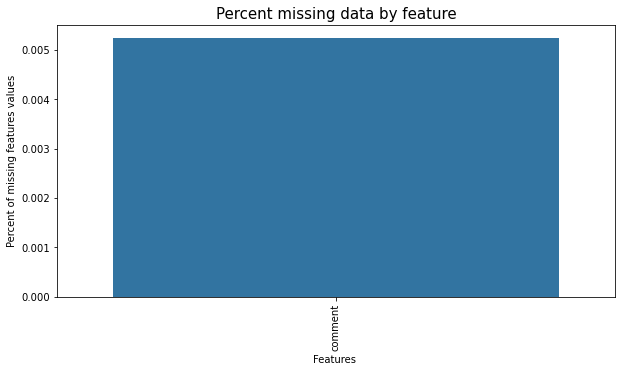

In [13]:
f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation='90')
sns.barplot(x=data_nan.index, y=data_nan)
plt.xlabel('Features ', fontsize=10)
plt.ylabel('Percent of missing features values', fontsize=10)
plt.title('Percent missing data by feature', fontsize=15)

In [14]:
#Univarient Analysis
def perc_on_bar(x):
    total_len = len(data[x]) # length of the column
    plt.figure(figsize=(15,7))
    ax = sns.countplot(data[x],palette='Paired')
    for p in ax.patches:
        per = '{:.1f}%'.format(100 * p.get_height()/total_len) 
        x = p.get_x() + p.get_width() / 2 - 0.10
        y = p.get_y() + p.get_height()          
        ax.annotate(per, (x, y), size = 12) # annotate the percantage 
    plt.show() # show the plot

In [15]:
def plot_categories(feature,title1):
    plt.figure(figsize=(15,8))
    count=data[feature].value_counts()
    sns.barplot(x=count[:15].values, y=count[:15].index)
    plt.title('(a)'+title1,fontsize=15)
    plt.xlabel('Counts', fontsize=13)
    plt.show()

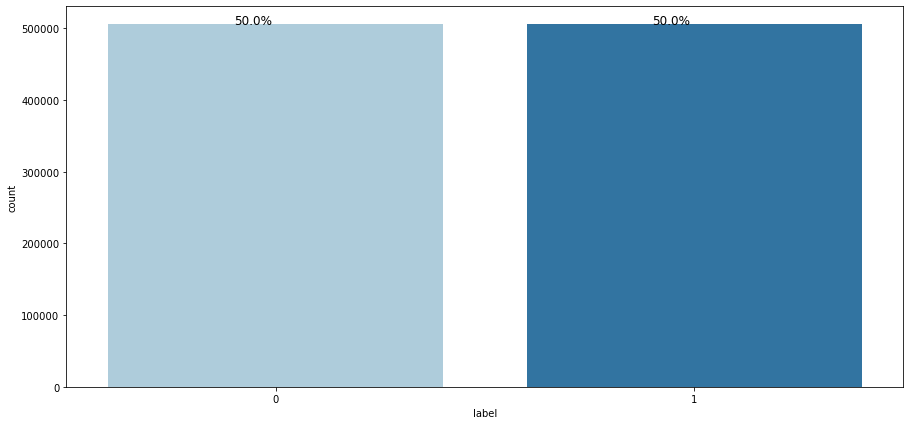

In [16]:
#Label
perc_on_bar('label')

In [17]:
#Observation.
    #label is target variable contain two values which are equally distributed.
#Text Preprocessing
data['comment']=data['comment'].fillna('No Comment')

In [18]:
# Remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [21]:
# Remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase
from nltk.corpus import stopwords
from tqdm import tqdm
import re
stopwords = stopwords.words('english')
def preprocess(text_col,stopword):
    preprocessed = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sentence=str(sentence)
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        #remove stop words
        #decontraction
        sent=decontractions(sent)
        #Remove emoji
        sent=deEmojify(sent)
        if stopword:
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
        else:
            sent = ' '.join(e for e in sent.split())
        # to lowercase
        preprocessed.append(sent.lower().strip())
    return preprocessed
data['comment']=preprocess(data['comment'],stopword=False)
data['parent_comment']=preprocess(data['parent_comment'],stopword=False)

100%|██████████| 1010826/1010826 [00:31<00:00, 31948.84it/s]


In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sudin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
from nltk.corpus import stopwords
from tqdm import tqdm
import re
stopwords = stopwords.words('english')
def preprocess(text_col,stopword):
    preprocessed = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sentence=str(sentence)
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        #remove stop words
        #decontraction
        sent=decontractions(sent)
        #Remove emoji
        sent=deEmojify(sent)
        if stopword:
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
        else:
            sent = ' '.join(e for e in sent.split())
        # to lowercase
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [24]:
data['comment']=preprocess(data['comment'],stopword=False)

100%|██████████| 1010826/1010826 [00:23<00:00, 42429.38it/s]


In [25]:
data['parent_comment']=preprocess(data['parent_comment'],stopword=False)

100%|██████████| 1010826/1010826 [00:30<00:00, 32876.96it/s]


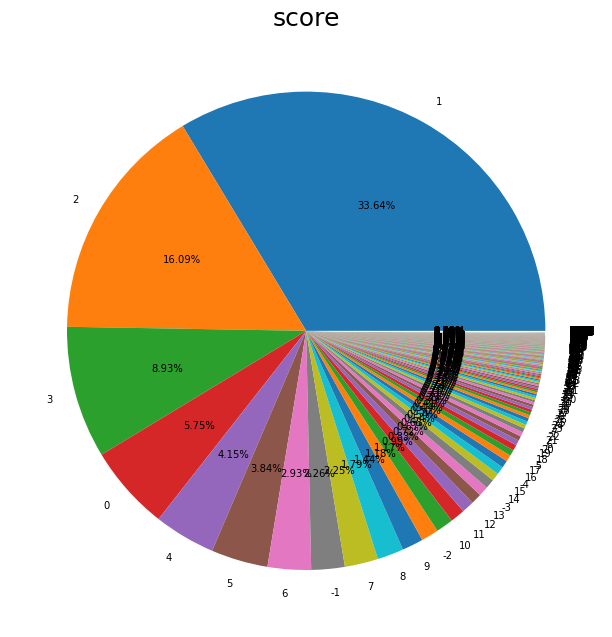

In [26]:
#Score
labels=data['score'].value_counts().index
sizes=data['score'].value_counts().values
plt.figure(figsize=(11,11))
plt.pie(sizes,labels=labels,autopct="%1.2f%%")
plt.title("score",size=25)
plt.show()

In [27]:
score_count=Counter(list(data['score']))
score_count.most_common(10)

[(1, 340017),
 (2, 162678),
 (3, 90290),
 (0, 58145),
 (4, 41979),
 (5, 38802),
 (6, 29600),
 (-1, 22810),
 (7, 22769),
 (8, 18064)]

In [28]:
#Observation.
#(a) Pie chart of score variable.
#(b) Top 10 score value.
#Author
author_type_count=Counter(list(data['author']))
author_type_count.most_common(10)

[('Biffingston', 845),
 ('pokemon_fetish', 432),
 ('NeonDisease', 422),
 ('ShyBiDude89', 404),
 ('ivsciguy', 342),
 ('mad-n-fla', 318),
 ('mindlessrabble', 302),
 ('Canada_girl', 300),
 ('Chaoslab', 252),
 ('sleaze_bag_alert', 251)]

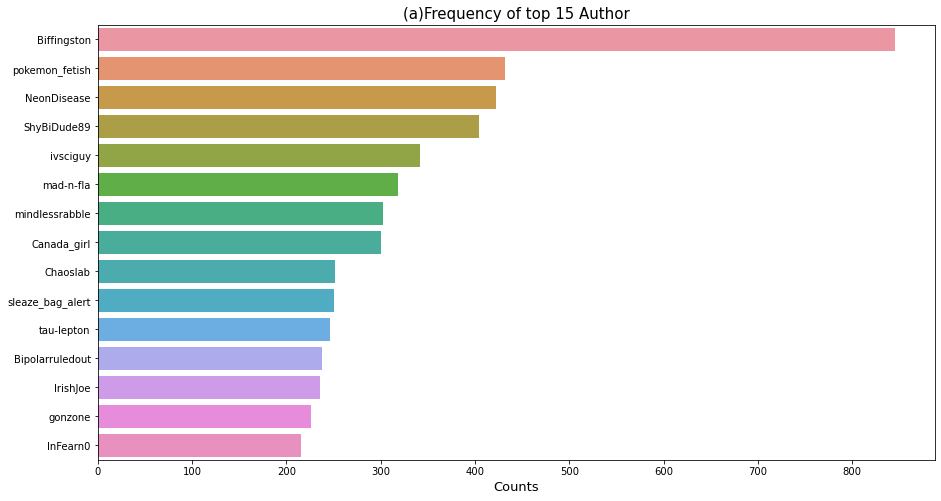

In [29]:
title1='Frequency of top 15 Author'
plot_categories('author',title1)

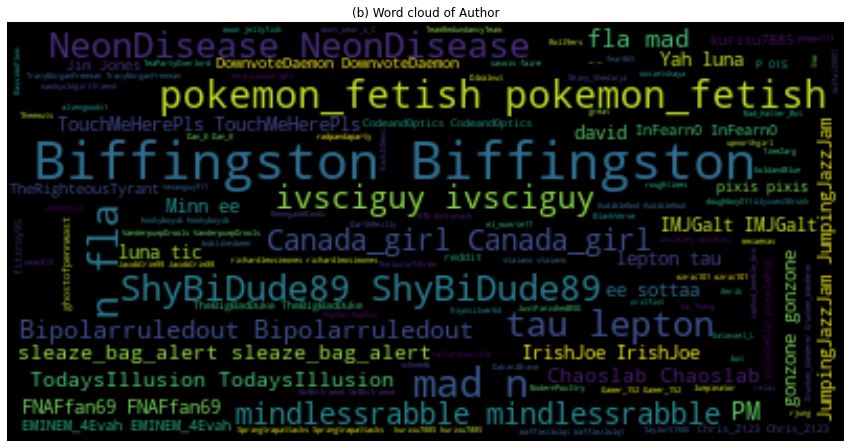

In [30]:
plt.figure(figsize = (15, 15))
plt.title("(b) Word cloud of Author")
wc = WordCloud().generate(" ".join(data['author'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [31]:
#Observation.
#figure (a) Frequency of top 15 Author.
#figure (b) WordCloud of Author most occuring Author is pokemon,ShyBiDude.

In [32]:
#Subreddit
subreddit_type_count=Counter(list(data['subreddit']))
subreddit_type_count.most_common(10)

[('AskReddit', 65677),
 ('politics', 39496),
 ('worldnews', 26377),
 ('leagueoflegends', 21037),
 ('pcmasterrace', 18988),
 ('funny', 17939),
 ('news', 16891),
 ('pics', 16154),
 ('todayilearned', 14161),
 ('nfl', 14150)]

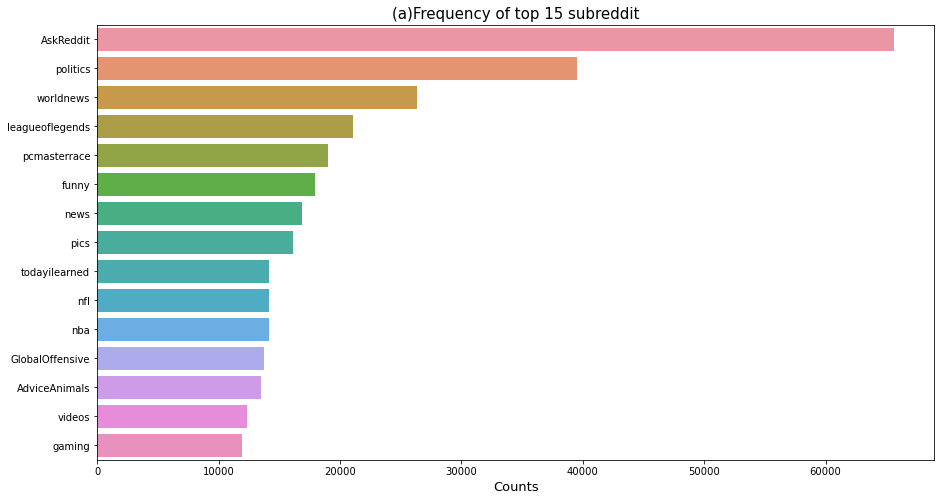

In [33]:
title1='Frequency of top 15 subreddit'
plot_categories('subreddit',title1)

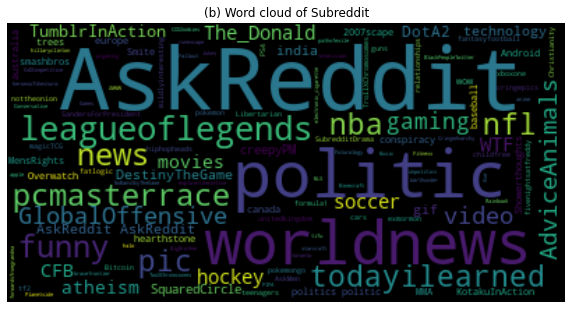

In [34]:
plt.figure(figsize = (10, 10))
plt.title("(b) Word cloud of Subreddit")
wc = WordCloud().generate(" ".join(data['subreddit'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
#Observation.
#figure (a) Frequency of Top 15 subreddit.
#figure (b) WordCloud of Subreddit most occuring word is Politic,AskReddit,worldnews.

In [36]:
#Comment
comment_type_count=Counter(list(data['comment']))
comment_type_count.most_common(10)

[('you forgot the', 1921),
 ('yes', 1328),
 ('', 1089),
 ('no', 928),
 ('thanks', 835),
 ('you dropped this', 771),
 ('lol', 624),
 ('thank you', 523),
 ('you forgot your', 453),
 ('you forgot', 412)]

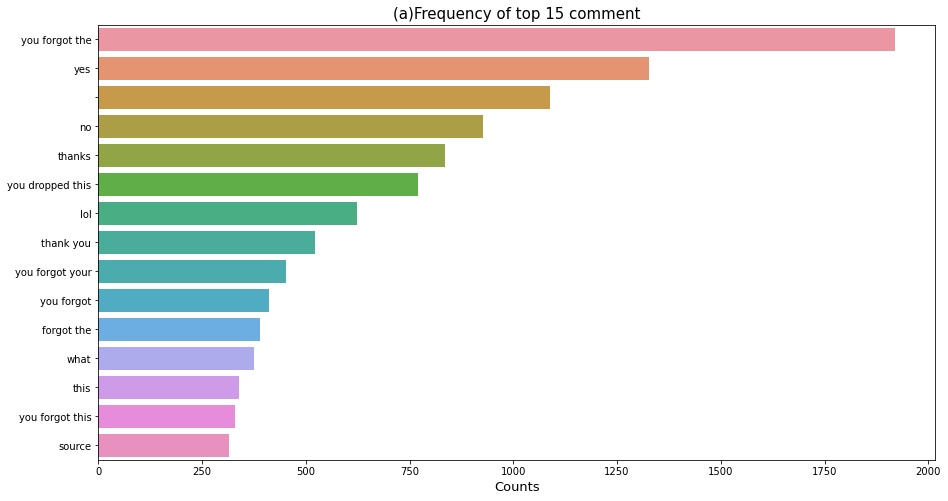

In [37]:
title1='Frequency of top 15 comment'
plot_categories('comment',title1)

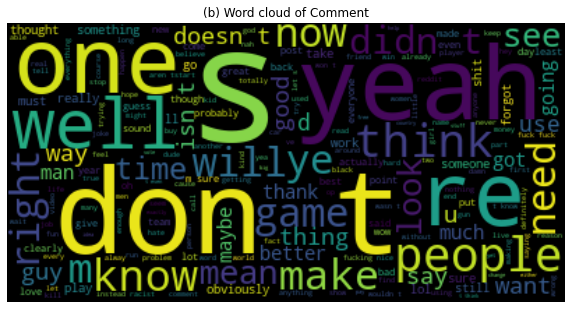

In [38]:
plt.figure(figsize = (10, 10))
plt.title("(b) Word cloud of Comment")
wc = WordCloud().generate(" ".join(data['comment'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [39]:
#Observation.
#figure (a) Frequency of top 15 word in comment.
#figure (b) WordCloud of comment most occuring word is Yeah,one,Well.

In [40]:
#Parent Comment
parent_comment_type_count=Counter(list(data['parent_comment']))
parent_comment_type_count.most_common(10)

[('', 380),
 ('me irl', 370),
 ('why', 362),
 ('no', 344),
 ('yes', 342),
 ('what', 228),
 ('cat', 142),
 ('lol', 124),
 ('thanks', 111),
 ('nope', 111)]

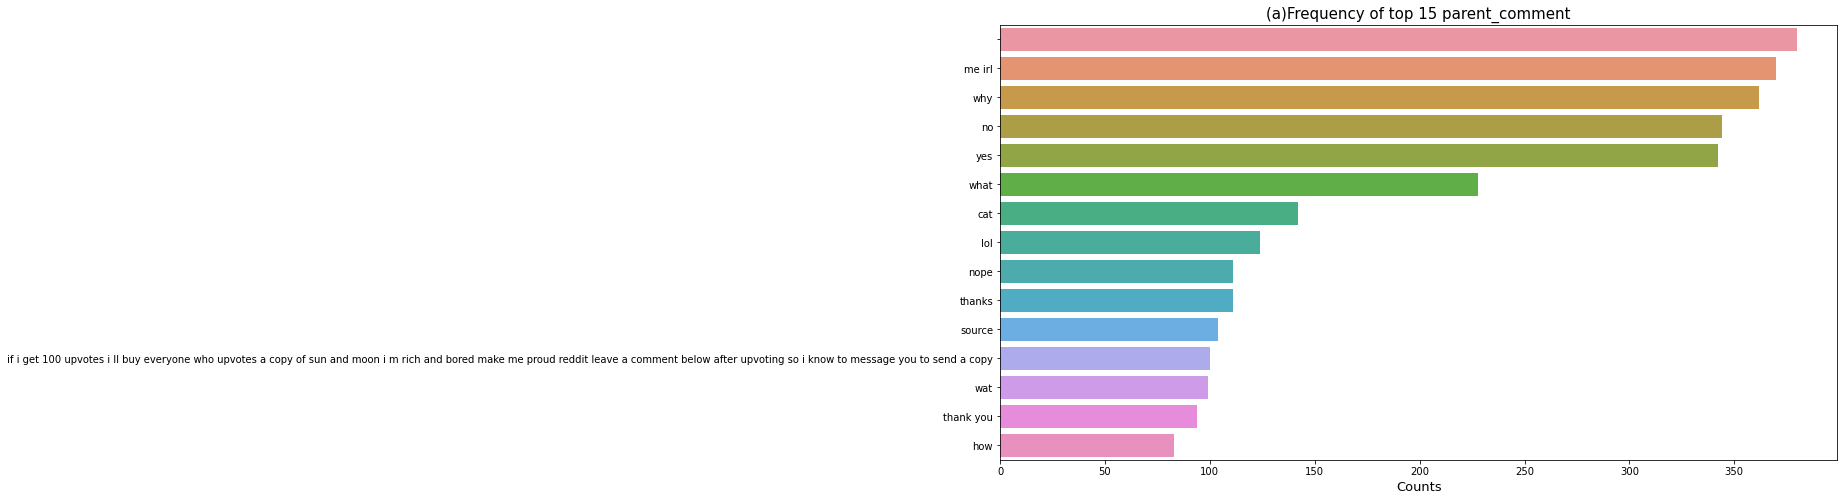

In [41]:
title1='Frequency of top 15 parent_comment'
plot_categories('parent_comment',title1)

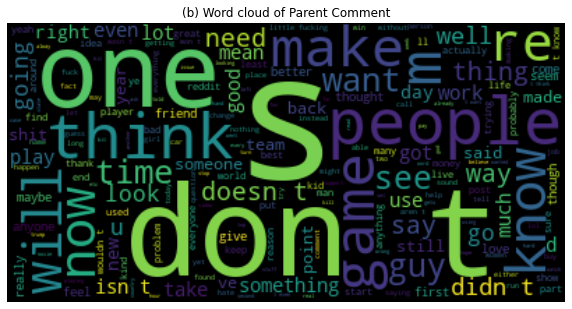

In [42]:
plt.figure(figsize = (10, 10))
plt.title("(b) Word cloud of Parent Comment")
wc = WordCloud().generate(" ".join(data['parent_comment'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [43]:
#Observation.
#figure (a) Frequency of top 15 words in parent_comment.
#figure (b) WordCloud of top words in parent_comment most occuring word is think,now,one,say.

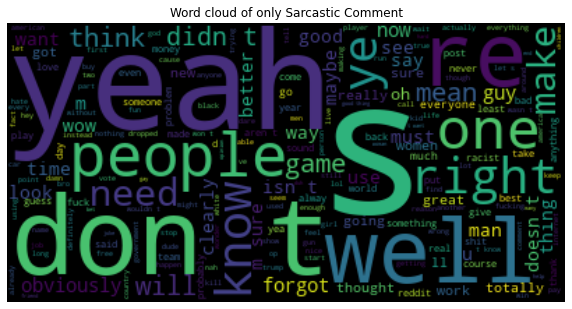

In [44]:
#Word Cloud of sarcastic comment

data1=data[data['label']==1]
plt.figure(figsize = (10, 10))
plt.title("Word cloud of only Sarcastic Comment")
wc = WordCloud().generate(" ".join(data1['comment'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [45]:
#Observation.
#WordCloud of sarcastic word in comment.

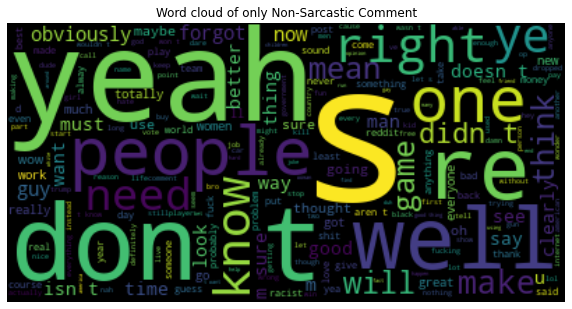

In [46]:
#Word Cloud of Non Sarcastic comment

data2=data[data['label']==0]
plt.figure(figsize = (10, 10))
plt.title("Word cloud of only Non-Sarcastic Comment")
wc = WordCloud().generate(" ".join(data1['comment'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [47]:
#Observation.
#WordCloud of non sarcastic word in comment.

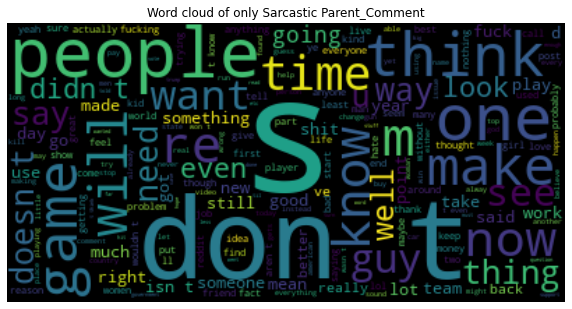

In [48]:
#Word Cloud of sarcastic parent_comment

data1=data[data['label']==1]
plt.figure(figsize = (10, 10))
plt.title("Word cloud of only Sarcastic Parent_Comment")
wc = WordCloud().generate(" ".join(data1['parent_comment'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [49]:
#Observation.
#WordCloud of sarcastic word in parent comment.

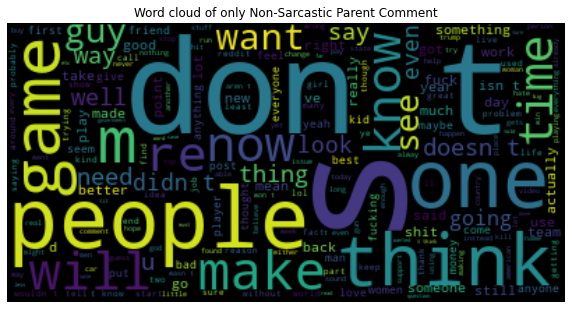

In [50]:
#Word Cloud of non sarcastic parent_comment

data2=data[data['label']==0]
plt.figure(figsize = (10, 10))
plt.title("Word cloud of only Non-Sarcastic Parent Comment")
wc = WordCloud().generate(" ".join(data1['parent_comment'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()
#Observation.
#WordCloud of non sarcastic word in parent comment.

In [51]:
def plot(x,target='label'):
    fig,axs = plt.subplots(2,2,figsize=(12,10))
    axs[0, 0].set_title('Distribution of an Sarcastic')
    sns.distplot(data[(data[target] == 1)][x],ax=axs[0,0],color='teal')
    axs[0, 1].set_title('Distribution of an non sarcastic')
    sns.distplot(data[(data[target] == 0)][x],ax=axs[0,1],color='orange')
    axs[1,0].set_title('Boxplot of ' + x + ' w.r.t label')
    sns.boxplot(data[target],data[x],ax=axs[1,0],palette='gist_rainbow')
    axs[1,1].set_title('Boxplot of ' + x + ' w.r.t label - Without outliers')
    sns.boxplot(data[target],data[x],ax=axs[1,1],showfliers=False,palette='gist_rainbow')
    plt.tight_layout()
    plt.show()

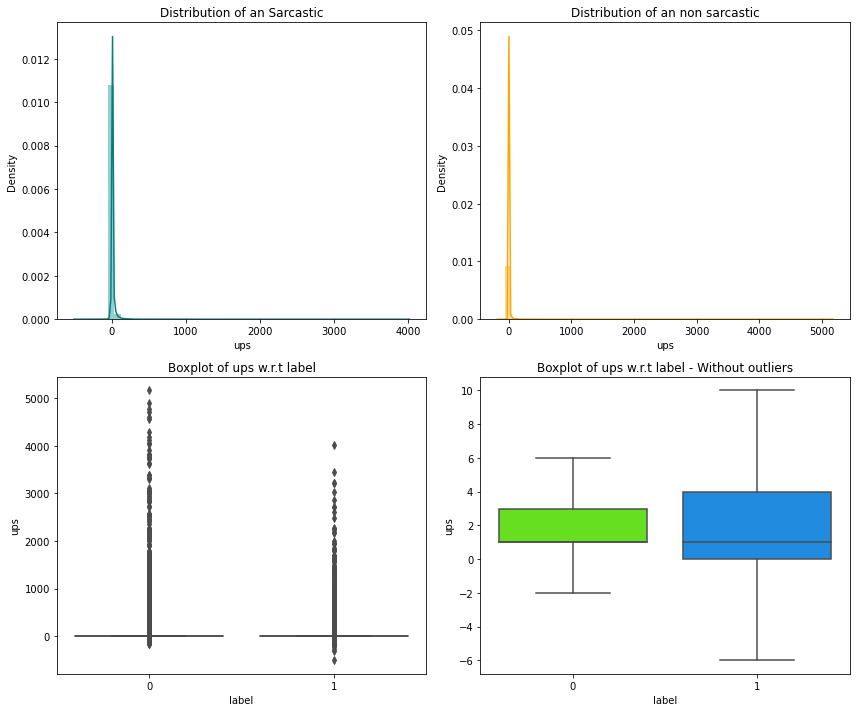

In [52]:
#label v/s Ups
plot('ups')

In [53]:
#Observation
#Upvotes follow similar distribution for sarcastic and non sarcstic comment.
#Upvotes contain huge number of outliers if we remove outliers then mean for both sarcastic and non sarcastic is approx to 2.

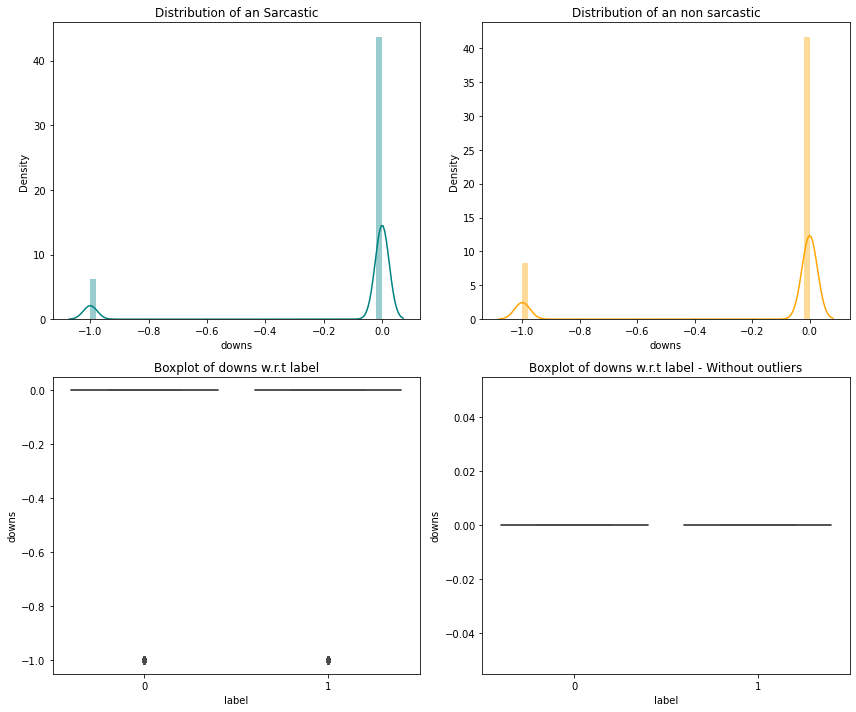

In [54]:
#label v/s downs
plot('downs')

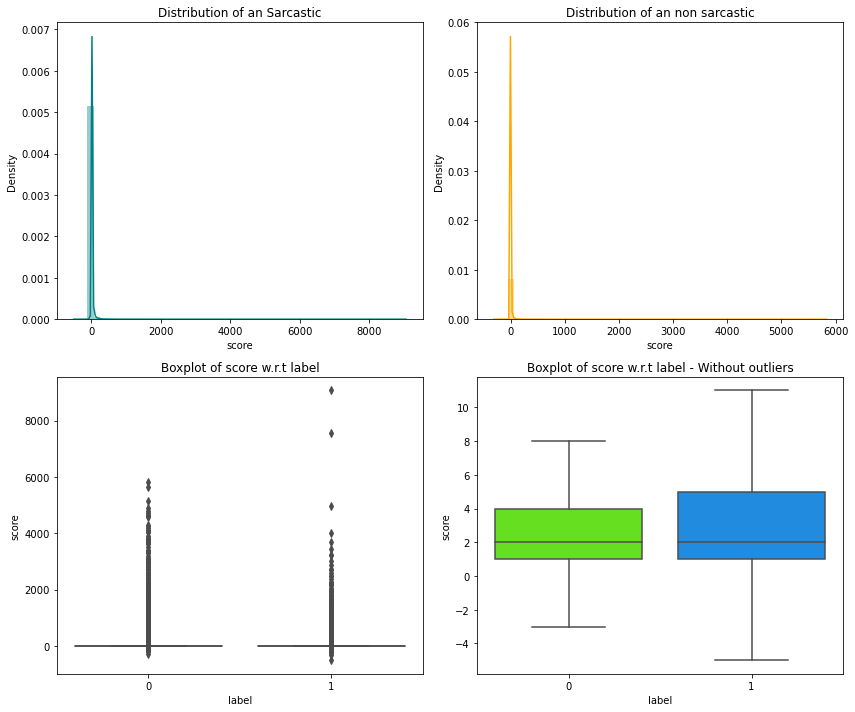

In [55]:
plot('score')

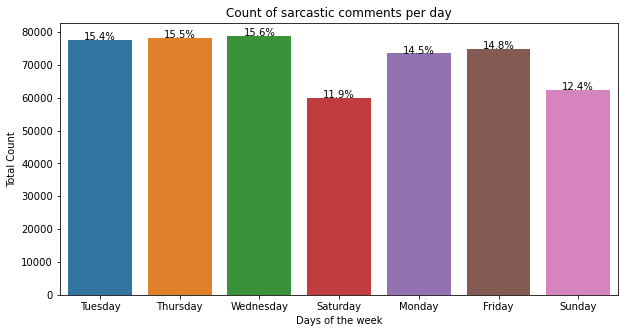

In [56]:
#Add new column Day.
data['created_utc'] = pd.to_datetime(data['created_utc'], format = '%Y-%m-%d %H:%M:%S')
data['Day of Week'] = data['created_utc'].dt.day_name()
plt.figure(figsize=(10,5))
ax = sns.countplot(x='Day of Week',  data= data.loc[data['label']==1])
ax.set(title = "Count of sarcastic comments per day", xlabel="Days of the week", ylabel = "Total Count")
total = float(len(data))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 7,
            '{:1.1f}%'.format((height/total)*100*2),
            ha="center") 
plt.show()

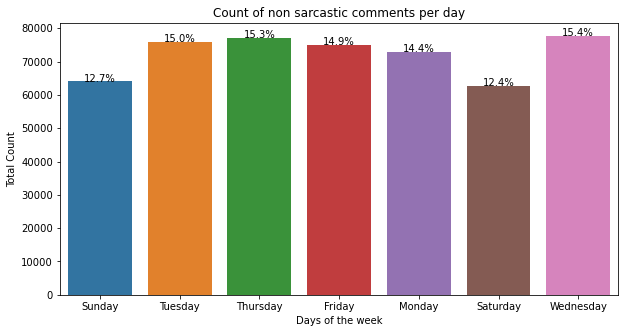

In [57]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='Day of Week',  data= data.loc[data['label']==0])
ax.set(title = "Count of non sarcastic comments per day", xlabel="Days of the week", ylabel = "Total Count")
total = float(len(data))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 7,
            '{:1.1f}%'.format((height/total)*100*2),
            ha="center") 
plt.show()

In [58]:
#Observation.
#People less comments on weekend.

In [59]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Sudin\AppData\Roaming\nltk_data...


True

In [60]:
#Add New Column Sentiment Score.
import nltk
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    for sentence in tqdm(data['parent_comment'].values): 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu

In [61]:
data['compound'],data['negative'],data['positive'],data['neutral']=generate_sentiment_scores(data)

100%|██████████| 1010826/1010826 [03:58<00:00, 4245.35it/s]


In [62]:
#Add new Column Comment length.
data['com_len']=data['comment'].apply(lambda x:len(x.split()))

In [63]:
#Add new Column parent Comment length.
data['parent_com_len']=data['parent_comment'].apply(lambda x:len(x.split()))

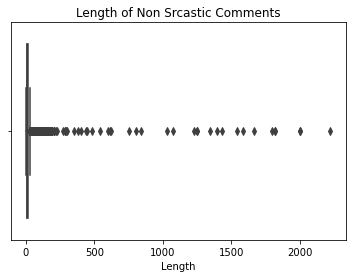

In [64]:
#Non Sarcastic comment length

sns.boxplot(x= data.loc[data['label'] == 0, 'com_len']).set(title = 'Length of Non Srcastic Comments', xlabel = 'Length')
plt.show()

In [65]:
data1=data[data['label']==0]
for i in range(0,101,10):
    print("{} th percentile is: {}".format(i,np.percentile(data1['com_len'],i)))

0 th percentile is: 0.0
10 th percentile is: 2.0
20 th percentile is: 4.0
30 th percentile is: 5.0
40 th percentile is: 7.0
50 th percentile is: 9.0
60 th percentile is: 11.0
70 th percentile is: 13.0
80 th percentile is: 16.0
90 th percentile is: 22.0
100 th percentile is: 2222.0


In [66]:
for i in range(90,101,1):
    print("{}th percentile is: {}".format(i,np.percentile(data1['com_len'],i)))

90th percentile is: 22.0
91th percentile is: 23.0
92th percentile is: 24.0
93th percentile is: 25.0
94th percentile is: 26.0
95th percentile is: 28.0
96th percentile is: 30.0
97th percentile is: 32.0
98th percentile is: 36.0
99th percentile is: 43.0
100th percentile is: 2222.0


In [67]:
value=data1['com_len'].values
value= np.sort(value,axis = None)
for i in np.arange(0.0, 1.0, 0.1):
    print("{}th percentile is {}".format(99+i,value[int(len(value)*(float(99+i)/100))]))
print("100th percentile is ",value[-1])

99.0th percentile is 43
99.1th percentile is 44
99.2th percentile is 45
99.3th percentile is 47
99.4th percentile is 49
99.5th percentile is 51
99.6th percentile is 53
99.7th percentile is 57
99.8th percentile is 63
99.9th percentile is 74
100th percentile is  2222


In [68]:
#Observation.
#Boxplot of non Sarcastic comment length.
#Maxlength of non sarcastic length is 2222.

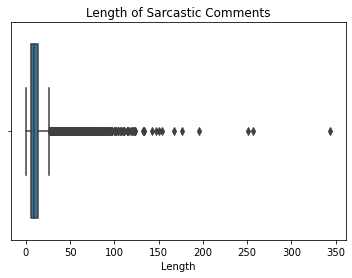

In [69]:
#Sarcastic comment Length

sns.boxplot(x= data.loc[data['label'] == 1, 'com_len']).set(title = 'Length of Sarcastic Comments', xlabel = 'Length')
plt.show()

In [70]:
data1=data[data['label']==1]
for i in range(0,101,10):
    print("{} th percentile is: {}".format(i,np.percentile(data1['com_len'],i)))

0 th percentile is: 0.0
10 th percentile is: 3.0
20 th percentile is: 5.0
30 th percentile is: 6.0
40 th percentile is: 8.0
50 th percentile is: 9.0
60 th percentile is: 11.0
70 th percentile is: 13.0
80 th percentile is: 15.0
90 th percentile is: 20.0
100 th percentile is: 344.0


In [71]:
for i in range(90,101,1):
    print("{}th percentile is: {}".format(i,np.percentile(data1['com_len'],i)))

90th percentile is: 20.0
91th percentile is: 20.0
92th percentile is: 21.0
93th percentile is: 22.0
94th percentile is: 23.0
95th percentile is: 24.0
96th percentile is: 25.0
97th percentile is: 27.0
98th percentile is: 30.0
99th percentile is: 35.0
100th percentile is: 344.0


In [72]:
value=data1['com_len'].values
value= np.sort(value,axis = None)
for i in np.arange(0.0, 1.0, 0.1):
    print("{}th percentile is {}".format(99+i,value[int(len(value)*(float(99+i)/100))]))
print("100th percentile is ",value[-1])

99.0th percentile is 35
99.1th percentile is 36
99.2th percentile is 37
99.3th percentile is 38
99.4th percentile is 39
99.5th percentile is 40
99.6th percentile is 42
99.7th percentile is 45
99.8th percentile is 49
99.9th percentile is 56
100th percentile is  344


In [73]:
#Observation
#Boxplot of Sarcastic comment length.
#Maxlength of sarcastic length is 344.

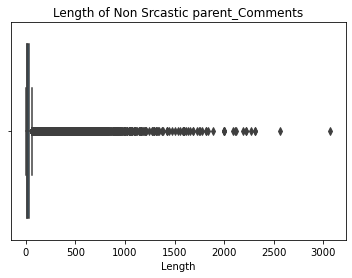

In [74]:
#Non Sarcastic Parent_length

sns.boxplot(x= data.loc[data['label'] == 0, 'parent_com_len']).set(title = 'Length of Non Srcastic parent_Comments', xlabel = 'Length')
plt.show()

In [75]:
data1=data[data['label']==0]
for i in range(0,101,10):
    print("{} th percentile is: {}".format(i,np.percentile(data1['parent_com_len'],i)))

0 th percentile is: 0.0
10 th percentile is: 4.0
20 th percentile is: 6.0
30 th percentile is: 8.0
40 th percentile is: 11.0
50 th percentile is: 14.0
60 th percentile is: 18.0
70 th percentile is: 23.0
80 th percentile is: 33.0
90 th percentile is: 54.0
100 th percentile is: 3070.0


In [76]:
for i in range(90,101,1):
    print("{}th percentile is: {}".format(i,np.percentile(data1['parent_com_len'],i)))

90th percentile is: 54.0
91th percentile is: 58.0
92th percentile is: 62.0
93th percentile is: 67.0
94th percentile is: 74.0
95th percentile is: 82.0
96th percentile is: 93.0
97th percentile is: 108.0
98th percentile is: 133.0
99th percentile is: 186.0
100th percentile is: 3070.0


In [77]:
value=data1['parent_com_len'].values
value= np.sort(value,axis = None)
for i in np.arange(0.0, 1.0, 0.1):
    print("{}th percentile is {}".format(99+i,value[int(len(value)*(float(99+i)/100))]))
print("100th percentile is ",value[-1])

99.0th percentile is 186
99.1th percentile is 195
99.2th percentile is 206
99.3th percentile is 219
99.4th percentile is 236
99.5th percentile is 256
99.6th percentile is 286
99.7th percentile is 323
99.8th percentile is 383
99.9th percentile is 522
100th percentile is  3070


In [78]:
#Observation.
#Boxplot of Sarcastic parent comment length.
#Maxlength of sarcastic length is 3070.

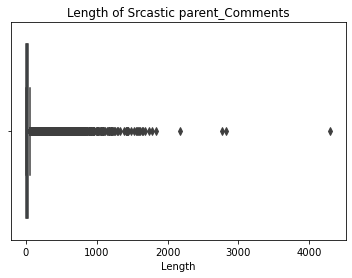

In [79]:
#Sarcastic Parent_comment
sns.boxplot(x= data.loc[data['label'] == 1, 'parent_com_len']).set(title = 'Length of Srcastic parent_Comments', xlabel = 'Length')
plt.show()

In [80]:
data1=data[data['label']==1]
for i in range(0,101,10):
    print("{} th percentile is: {}".format(i,np.percentile(data1['parent_com_len'],i)))

0 th percentile is: 0.0
10 th percentile is: 5.0
20 th percentile is: 7.0
30 th percentile is: 9.0
40 th percentile is: 12.0
50 th percentile is: 14.0
60 th percentile is: 18.0
70 th percentile is: 24.0
80 th percentile is: 33.0
90 th percentile is: 52.0
100 th percentile is: 4298.0


In [81]:
for i in range(90,101,1):
    print("{}th percentile is: {}".format(i,np.percentile(data1['parent_com_len'],i)))

90th percentile is: 52.0
91th percentile is: 55.0
92th percentile is: 59.0
93th percentile is: 64.0
94th percentile is: 70.0
95th percentile is: 78.0
96th percentile is: 87.0
97th percentile is: 101.0
98th percentile is: 124.0
99th percentile is: 174.0
100th percentile is: 4298.0


In [82]:
value=data1['parent_com_len'].values
value= np.sort(value,axis = None)
for i in np.arange(0.0, 1.0, 0.1):
    print("{}th percentile is {}".format(99+i,value[int(len(value)*(float(99+i)/100))]))
print("100th percentile is ",value[-1])

99.0th percentile is 174
99.1th percentile is 182
99.2th percentile is 193
99.3th percentile is 205
99.4th percentile is 221
99.5th percentile is 238
99.6th percentile is 262
99.7th percentile is 297
99.8th percentile is 354
99.9th percentile is 462
100th percentile is  4298


In [83]:
#Observation.
#Boxplot of Sarcastic parent comment length.
#Maxlength of sarcastic length is 4298.

<AxesSubplot:>

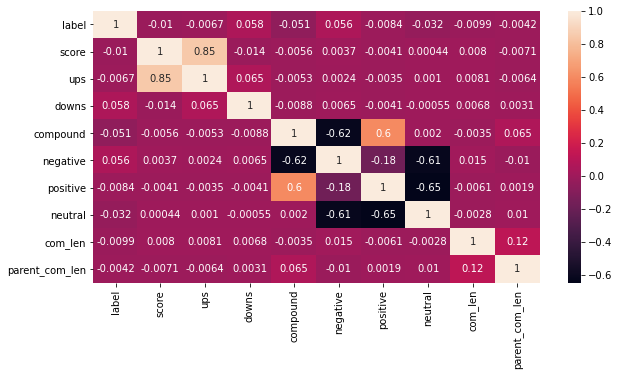

In [84]:
#Correlation b/w numeric variable
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(),annot=True)

In [ ]:
#Observation.
#label and score are highly correlated to each other.
#comment_len and parent_comment_len.